# SMS Spam Detection AI test

This notebook aims to demonstrate a task to predict if a given SMS it is or not a spam. 
Throughout this demonstration, some data cleaning and NLP concepts will be applied. At the final, after process our data, we will train a model and check if our concepts were well or badly applied. 

This notebook is part of a practical prove provided from NUVEO.

### Imports

For the purpose of this task, the following libraries will be helping us to present the ideas through this notebook.

In [45]:
import matplotlib.pyplot as plt

import pandas as pd
import nltk

import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score

%matplotlib inline
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data study

We will try to understand a little bit more of our data and which metrics we can take to help in our future model training process.

To read our data, we are going to use pandas library and \t separator to divide our data in the correct way. Our columns will be named `outcome` and `message`


In [46]:
sms_data = pd.read_csv('./TrainingSet/sms-hamspam-train.csv', sep='\t',names=["outcome","message"])
sms_data.head()

,outcome,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,spam,"SMSSERVICES. for yourinclusive text credits, p..."
2,spam,25p 4 alfie Moon's Children in need song on ur...
3,spam,U have a secret admirer. REVEAL who thinks U R...
4,spam,"Dear Voucher Holder, To claim this weeks offer..."


Checking the distribution over the outcomes seems like the data is not very balanced.

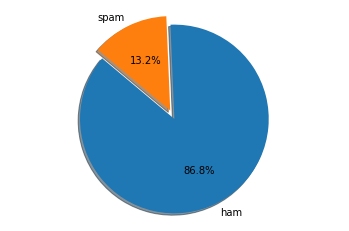

In [47]:
labels = 'ham','spam'
sms_data['outcome'].value_counts()

sizes = list(sms_data['outcome'].value_counts())

explode=(0.1, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, shadow=True,autopct='%1.1f%%', startangle=140)
ax.axis('equal')
plt.show()


First, we can check over the message size to get some insight when we compare the outcomes. To test this hypothesis we are going to create a new column that contains then number of characters for message.

In [48]:
sms_data['len_sms'] = sms_data.apply(lambda x: len(x['message']), axis = 1)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

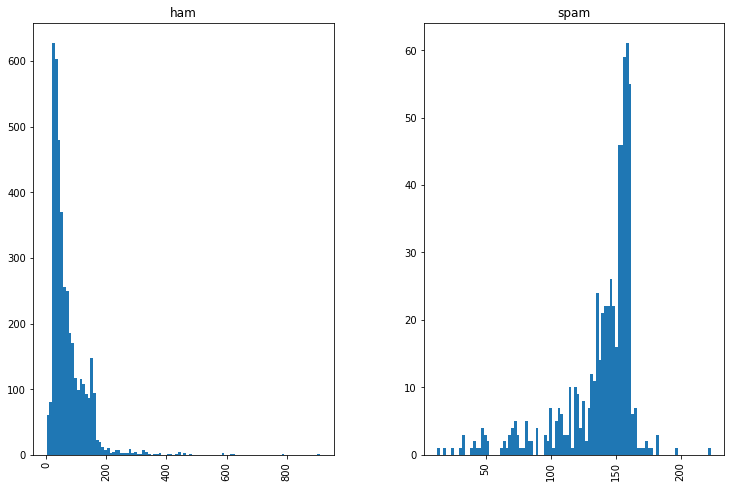

In [49]:
sms_data.hist(column='len_sms', by='outcome', bins=100,figsize=(12,8))

When we check this histogram distribution that compare both outcomes, it's possible to notice that the concentrations happens in different places for each histogram, given the idea that this variable can be important to predict if a message it is or it is not a spam.

Another point that can be important to this kind of task is the punctuation in each message. We will do the same thing that we did here, with a small difference that we will not count each punctuation, just if the message has or not the string.

In [50]:
def check_punctuation(message):
    """ Check if the given message has or not punctuation
    Args:
        message: An string
    Returns:
        str: return 1 if the message contains a punctuation
                0 if the message does not contains
    """
    splited_message = message.split(" ")
    for i in splited_message:
        if i in string.punctuation:
            return 1
    return 0

In [51]:
sms_data['punc_sms'] = sms_data.apply(lambda x: check_punctuation(x['message']), axis = 1)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

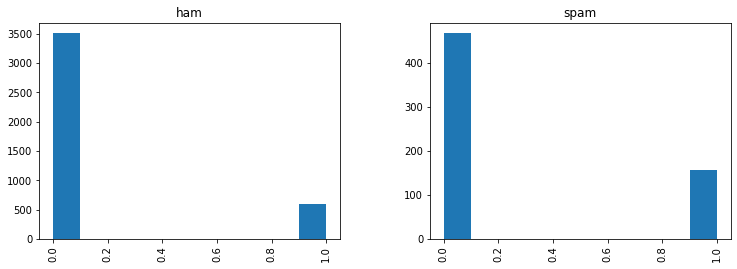

In [52]:
sms_data.hist(column='punc_sms', by='outcome',figsize=(12,4))

As is possible to notice, the proportion for both the outcomes related if the message has or not punctation is very equally, giving the impression that this metric maybe not that important for us. We can check the proportion for each outcome in the following way:

In [53]:
proportion_ham = len(sms_data[(sms_data['outcome']=='ham') & 
                              (sms_data['punc_sms'] == 1)]) / len(sms_data[(sms_data['outcome']=='ham')])
print("Has punctuation proportion to ham outcome is: {}".format(round(proportion_ham,3)))

proportion_spam = len(sms_data[(sms_data['outcome']=='spam') & 
                              (sms_data['punc_sms'] == 1)]) / len(sms_data[(sms_data['outcome']=='spam')])

print("Has punctuation proportion to spam outcome is: {}".format(round(proportion_spam,3)))

Has punctuation proportion to ham outcome is: 0.145
Has punctuation proportion to ham outcome is: 0.251


As we can, the difference is not that big, so we can through it up this metric.

Looking further into our data, another characteristic can be seeing. A lot of messages have full words that have all of their letters in upper case. So, let's check the occurrence in both of our outcomes.

In [54]:
def uppercase_pct(message):
    """Calculate the percentage of the given message
        that it is upper case
    Args:
        message: An string
    Returns:
        str: return 1 if the message contains a punctuation
                0 if the message does not contains
    """
    
    total_upper = sum([1 for letter in message if letter.isupper()])
    
    return total_upper/(len(message) - message.count(" "))

In [55]:
sms_data['sms_upper_pct'] = sms_data.apply(lambda x: uppercase_pct(x['message']), axis = 1)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

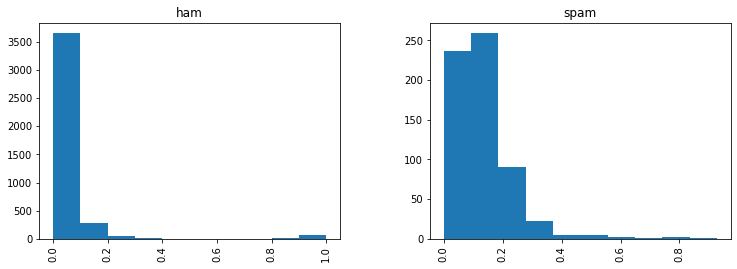

In [56]:
sms_data.hist(column='sms_upper_pct', by='outcome',figsize=(12,4))

As we can see, the `spam` outcome looks to have less concentrated data. At the same time, the `ham` outcome is the opposite. To our purpose, this new metric can be important.

After this tiny study and creation of new metrics, we now have the following dataset:

In [57]:
sms_data.head()

,outcome,message,len_sms,punc_sms,sms_upper_pct
0,ham,"Go until jurong point, crazy.. Available only ...",111,0,0.032609
1,spam,"SMSSERVICES. for yourinclusive text credits, p...",156,0,0.175182
2,spam,25p 4 alfie Moon's Children in need song on ur...,161,0,0.053435
3,spam,U have a secret admirer. REVEAL who thinks U R...,147,0,0.198347
4,spam,"Dear Voucher Holder, To claim this weeks offer...",152,0,0.100775


### Data processing

In this section, we are going to use some techniques to let our textual data cleaner and simpler. Doing this, the model can learn better and be more powerful.

**Bag of words, lower_case  and ponctuation cleaning:**
- Here we going to clean our data by deleting all words/occurences that following at least one of this cases. This process can help to (1) generalize lower/upper case in just one token (2) exclude unecessary common words or ponctuation that will not help at all the model
     
**Stemmers:**
- Following the same idea of generalize some words, we can use [stemmers](http://www.nltk.org/book/ch03.html) to normalize a set of words. Stemmers can be understood as a techinique that make words in different verbal times be the same.
 
**Tf-idf:**
- Tf-idf is a technique that applies a weight/score to all words in a given message. To calculate this score, tf-idf uses the term frequency over all corpus data and the frequency over the message. So, doing like this, the final message data will be a sparse vector and each message will be transformed to columns where just the words in this message will be scored.


Bellow, we define the functions and apply them over the dataset. We can see the modifications over each cell output.

In [58]:
def to_lower_case(message):
    """In case where "This" and "this" (for example) are part of
        the same setence, tokenize them both will give diferent token numbers for each.
        Transform the dataset in a case sensitive one
        
    Args:
        message: sms string
    Returns:
        return all word messages in lower case
    """
    
    return "".join([word.lower() for word in message])

def remove_ponct(message):
    """Remove any punctuation that exists on the given message
    Args:
        message: sms string
    Returns:
        return the message without any punctuation
    """
    
    return "".join([letter for letter in message if letter not in string.punctuation])

def remove_stop_words(message):
    """Remove any stop word from english that can may affet the model prediction
    Args:
        message: sms string
    Returns:
        return the messages without any stopwords from english vocabulary

    """
    splited_message = message.split()

    return " ".join([word for word in splited_message if word not in stopwords.words('english')])

def stemming_normalization(message):
    """Stemming the givef message using PorterStemmer()
    Args:
        message: sms string
    Returns:
        return a stemmed sentence
    """
    porter = nltk.PorterStemmer()
    splited_message = message.split()
    
    return " ".join([porter.stem(word) for word in splited_message])

**Applying lower case over all messages**

In [59]:
sms_data['lower_message'] = sms_data.apply(lambda x: to_lower_case(x['message']), axis = 1)
sms_data.drop(['message'],axis=1, inplace=True)
sms_data.head()

,outcome,len_sms,punc_sms,sms_upper_pct,lower_message
0,ham,111,0,0.032609,"go until jurong point, crazy.. available only ..."
1,spam,156,0,0.175182,"smsservices. for yourinclusive text credits, p..."
2,spam,161,0,0.053435,25p 4 alfie moon's children in need song on ur...
3,spam,147,0,0.198347,u have a secret admirer. reveal who thinks u r...
4,spam,152,0,0.100775,"dear voucher holder, to claim this weeks offer..."


**Removing punctuation over all messages**

In [60]:
sms_data['nopunct_message'] = sms_data.apply(lambda x: remove_ponct(x['lower_message']), axis = 1)
sms_data.drop(['lower_message'],axis=1, inplace=True)
sms_data.head()

,outcome,len_sms,punc_sms,sms_upper_pct,nopunct_message
0,ham,111,0,0.032609,go until jurong point crazy available only in ...
1,spam,156,0,0.175182,smsservices for yourinclusive text credits pls...
2,spam,161,0,0.053435,25p 4 alfie moons children in need song on ur ...
3,spam,147,0,0.198347,u have a secret admirer reveal who thinks u r ...
4,spam,152,0,0.100775,dear voucher holder to claim this weeks offer ...


**Removing stop words over all messages**

In [61]:
sms_data['no_stop_message'] = sms_data.apply(lambda x: remove_stop_words(x['nopunct_message']), axis = 1)
sms_data.drop(['nopunct_message'],axis=1, inplace=True)
sms_data.head()

,outcome,len_sms,punc_sms,sms_upper_pct,no_stop_message
0,ham,111,0,0.032609,go jurong point crazy available bugis n great ...
1,spam,156,0,0.175182,smsservices yourinclusive text credits pls got...
2,spam,161,0,0.053435,25p 4 alfie moons children need song ur mob te...
3,spam,147,0,0.198347,u secret admirer reveal thinks u r special cal...
4,spam,152,0,0.100775,dear voucher holder claim weeks offer pc pleas...


**Applying stemming over all messages**

In [62]:
sms_data['cleaned_message'] = sms_data.apply(lambda x: stemming_normalization(x['no_stop_message']), axis = 1)
sms_data.drop(['no_stop_message'],axis=1, inplace=True)
sms_data.head()

,outcome,len_sms,punc_sms,sms_upper_pct,cleaned_message
0,ham,111,0,0.032609,go jurong point crazi avail bugi n great world...
1,spam,156,0,0.175182,smsservic yourinclus text credit pl goto wwwco...
2,spam,161,0,0.053435,25p 4 alfi moon children need song ur mob tell...
3,spam,147,0,0.198347,u secret admir reveal think u r special call 0...
4,spam,152,0,0.100775,dear voucher holder claim week offer pc pleas ...


**Applying tf-idf over all messages**

In [74]:
tfidf_transformer = TfidfVectorizer()
tfidf_vec = tfidf_transformer.fit_transform(sms_data.cleaned_message)
tfidf_data = pd.DataFrame(tfidf_vec.toarray())
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7413,7414,7415,7416,7417,7418,7419,7420,7421,7422
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.191337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
print("At the final, tf-idf corpus has a total of {} words".format(len(tfidf_data.columns)))

At the final, tf-idf corpus has a total of 7423 words


Now that we have the claned/processed messages, we are going to divide only the data that was already separable to train in train/test in order to evaluate our model.

In [76]:
sms_data.drop(['cleaned_message'],axis=1, inplace=True)
final_data = pd.concat([sms_data, tfidf_data], axis=1, sort=False)
final_data.drop(['outcome'], axis=1, inplace=True)
final_data.head()

,len_sms,punc_sms,sms_upper_pct,0,1,2,3,4,5,6,...,7413,7414,7415,7416,7417,7418,7419,7420,7421,7422
0,111,0,0.032609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,156,0,0.175182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,161,0,0.053435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.191337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,147,0,0.198347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,152,0,0.100775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model fit

We now need to train and evaluate our model. For this purpose, we are going to use a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), model that fits a number of decision tree classifiers and uses averaging to improve accuracy and control over-fitting.

As we already have a testset to fill in, we will just give 10% of the data to evaluate the model fit.

In [77]:
msg_train, msg_test, label_train, label_test = train_test_split(final_data, sms_data['outcome'], test_size=0.1)

To help the improvment alredy gived by the model, we will here use the GridSearch, method that makes an exhaustive search over given parameters and uses cross validation to also control over-fitting.

In [78]:
model = RandomForestClassifier()

parameters = {
    'n_estimators'      : [50, 150,340],
    'max_depth'         : [8, 30, 60, None],
}

gs = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
gs_fit = gs.fit(msg_train, label_train)

Here, we can check the best solution that the model has found

In [79]:
print(gs_fit.best_params_)
print(gs_fit.best_score_)

{'max_depth': None, 'n_estimators': 340}
0.974834589064768


To evaluate our model, we need to predict a new data, in other words, a data that was never saw by the model. By predicting these data, we can calculate a variety of metrics and check if the model it is or not good enough. To calculate the most important ones, we just need to compare the predict data and their thurh value.

In [80]:
rf_prediction=gs_fit.predict(msg_test)

In [81]:
precision, recall, fscore, support = score(label_test,rf_prediction,pos_label='spam',average='binary')
print("Precision: {},\nRecall: {} \nFscore {}".format(round(precision,3), round(recall,3), round(fscore,3)))
print("Accuracy: {}".format( round((rf_prediction==label_test).sum() / len(rf_prediction),3)))

Precision: 1.0,
Recall: 0.887 
Fscore 0.94
Accuracy: 0.987


### AUC Roc

For binary and disbalanced tasks, measure the model over the simplests metrics can be not enougth. For this purpose, measure the [area under the Roc curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) seems like one good choise.

For short, the Roc curve describe how the model behaves in relation to TP (True Positives) and FP (False Positives). The AUC (Area Under Curve) describes how much the model can distinguish the classes.

In [82]:
# get the positive outcomes
rf_prediction_proba = gs_fit.predict_proba(msg_test)[::,1]
auc = metrics.roc_auc_score(label_test, rf_prediction_proba)
print("The Area Under the Roc Curve is: {}".format(round(auc, 3)))

The Area Under the Roc Curve is: 0.999


### Filling in the testset

#### Load testset data

The final task of this practical prove is to fill in the testset, which only contains a `message` column. So, to finish this task, we will load the testset and make the same changes that we made on the train set.

In [83]:
test_set = pd.read_csv('./TestSet/sms-hamspam-test.csv' ,sep='\t',names=["message"])
test_set.head()

,message
0,I know that my friend already told that.
1,It took Mr owl 3 licks
2,Dunno y u ask me.
3,K.k:)advance happy pongal.
4,I know but you need to get hotel now. I just g...


As we already saw the changes that we made on the train set, I'm skipping the explanations here.

In [84]:
# get the messages size
test_set['len_sms'] = test_set.apply(lambda x: len(x['message']), axis = 1)

# punctuation
test_set['punc_sms'] = test_set.apply(lambda x: check_punctuation(x['message']), axis = 1)

# upper case
test_set['sms_upper_pct'] = test_set.apply(lambda x: uppercase_pct(x['message']), axis = 1)
test_set.head()

,message,len_sms,punc_sms,sms_upper_pct
0,I know that my friend already told that.,40,0,0.030303
1,It took Mr owl 3 licks,22,0,0.117647
2,Dunno y u ask me.,17,0,0.076923
3,K.k:)advance happy pongal.,26,0,0.041667
4,I know but you need to get hotel now. I just g...,149,0,0.025424


In [85]:
# put lower case
test_set['lower_message'] = test_set.apply(lambda x: to_lower_case(x['message']), axis = 1)

# no punct case
test_set['nopunct_message'] = test_set.apply(lambda x: remove_ponct(x['lower_message']), axis = 1)
test_set.drop(['lower_message'],axis=1, inplace=True)

# remove stop words
test_set['no_stop_message'] = test_set.apply(lambda x: remove_stop_words(x['nopunct_message']), axis = 1)
test_set.drop(['nopunct_message'],axis=1, inplace=True)

# normalization
test_set['cleaned_message'] = test_set.apply(lambda x: stemming_normalization(x['no_stop_message']), axis = 1)
test_set.drop(['no_stop_message'],axis=1, inplace=True)

Here we will use the same instance tf-idf vectorizer

In [86]:
tfidf_vec = tfidf_transformer.transform(test_set.cleaned_message)
tfidf_test = pd.DataFrame(tfidf_vec.toarray())
tfidf_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7413,7414,7415,7416,7417,7418,7419,7420,7421,7422
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
test_set.drop(['cleaned_message'],axis=1, inplace=True)
final_data_test = pd.concat([test_set, tfidf_test], axis=1, sort=False)
final_data_test.head()

,message,len_sms,punc_sms,sms_upper_pct,0,1,2,3,4,5,...,7413,7414,7415,7416,7417,7418,7419,7420,7421,7422
0,I know that my friend already told that.,40,0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,It took Mr owl 3 licks,22,0,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Dunno y u ask me.,17,0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,K.k:)advance happy pongal.,26,0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,I know but you need to get hotel now. I just g...,149,0,0.025424,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
final_set = {"outcome":[],"message":final_data_test.message}
final_data_test.drop(['message'],axis=1, inplace=True)

Now we call fill in the testset 

In [89]:
final_data_test

,len_sms,punc_sms,sms_upper_pct,0,1,2,3,4,5,6,...,7413,7414,7415,7416,7417,7418,7419,7420,7421,7422
0,40,0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,0,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17,0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,149,0,0.025424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,25,0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,59,0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
844,59,0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
845,34,0,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
predictions = gs_fit.predict(final_data_test)

In [93]:
final_set["outcome"] = predictions
final_ans = pd.DataFrame(final_set)
final_ans.head()
final_ans.to_csv('final_ans.csv')